# Gradient Descent

Gradient Descent is an algorithm that minimizes some objective $J(\theta)$ where $\theta$ is $\in \mathbb{R}^d$ by iteratively updating the vector $\theta$ by moving in the direction of steepest descent multiplied by some step size or learning rate.

In essence, 

$\>\>\>\>$1: Pick an initial guess $\theta_0$    
$\>\>\>\>$2: $\>\>$while $J(\theta_{k+1}) - J(\theta_{k}) \leq precision$:    
$\>\>\>\>$3: $\>\>\>\>\>\>\>\>$ $\theta_{k+1}$ = $\theta_{k} -\nabla J_\theta(\theta_k)$ * $\alpha_k$.

This is relevant to Machine Learning because it offers a numerical solution to estimates of parameters that do not have a closed form solution.

## Estimating Multinomial Logistic Regression Parameters with Gradient Descent 

#### Cost Function
However, one needs to determine the objective $J(\theta)$ before executing this algorithm. In the case of linear regression, the sum of squared residuals could be used. In this case, one can use the idea of MLE to minimize the log liklihood.

In the case where $K = 2$, the likelihood function was $\prod_{i=1}^{n} p(\textbf x_i)^{y_i} (1-p(\textbf x_i))^{1-y_i}$ 

In the case where $K > 2$,

For $k \in K$ where $K$ is the set of labeled classes and $p$ is the number of features      
Let $p_k(\textbf x)$ be the posterior probability $P(Y = k | X = \bf x)$ and the model be defined as 

$p_k(\textbf x) = \frac{e^{\beta_{0}^k + \textbf w_k\cdot \textbf x}}{\sum_{k=1}^{K} e^{\beta_{0}^k + \textbf w_k\cdot \textbf x}}$ for $k=1...K$

One can see how each class $1 \leq k \leq K$ has its own set of parameters $w_k = (\beta_1,...,\beta_p)$

We want the optimal set of parameters(weights): argmax $L(\beta$ $|$ $ \textbf x)$

$$\prod_{k=1}^{K}P(Y = k | X = \textbf x_i)^{k_i} = \prod_{k=1}^{K} p_k(\textbf x_i)^{k_i}$$

Minimizing the negative log-liklihood is the same as maximizing the log-liklihood and can be taken as an average over an entire sample

$$J(\textbf w) = \frac{-1}{n}log\prod_{i=1}^{N}\prod_{k=1}^{K} p_k(\textbf x_i)^{k_i} = \frac{-1}{n}\sum_{i=1}^{N}\sum_{k=1}^{K} {k_i} * log(\hat{y}_{ki})$$

where $k_i$ is 1 if $\textbf x_i$ is labeled as class k

Finally, we introduce the L2 norm to obtain a regularized objective function.

$$J(\textbf w) = \frac{-1}{n}log\prod_{i=1}^{N}\prod_{k=1}^{K} p_k(\textbf x_i)^{k_i} = \frac{-1}{n}\sum_{i=1}^{N}\sum_{k=1}^{K} {k_i} * log(\hat{y}_{ki}) + \alpha R(\textbf w)$$

where $R(\textbf w) = ||\beta||^2_2 = \sum^{k}_{i=1}\beta_i^2$ and $p_k(\textbf x_i)^{k_i} = \hat{y}_{ki}$
#### Gradient of Cost Function

TODO

In [86]:
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

np.random.seed(0)

In [87]:
class GradientDescent:
    def __init__(self):
        self.rate = .1
        self.precision = .0001
        self.reg = .1
    
    # Pre: X - design matrix
    #      y - labeled classes
    #      w - pxk parameter matrix of current model
    # Post: a vector of K errors,one for each label
    def determineCost(self, X, y, w):
        yhat = self.softmax(np.dot(X,w))
        # sum K sets of squared beta_i
        R_w = self.reg * np.sum(w * w, axis = 0)
        # * operator will ensure a valid summation over all samples because the labels have been one-hot encoded
        J = -np.sum((y * np.log(yhat)),axis = 0)+R_w
        return J/X.shape[0]
    
    # Pre: X - design matrix
    #      y - labeled classes
    #      w - pxk parameter matrix of current model
    # Post: the gradient of J evaluated at w
    def gradient(self, X, y, w,batch_size):
        ind = np.random.choice(X.shape[0], batch_size-1, replace=False)
        X_sample = X[ind, :]
        y_sample = y[ind,:]
        yhat = self.softmax(np.dot(X_sample,w))
        gradient = np.dot(X_sample.transpose(),(yhat-y_sample))+self.reg * w
        return gradient/X_sample.shape[0]
    
    # Pre: z - x dot w of dimension (n*p)multiply(p*k=10)=>n*10
    # Post: Softmax score for each observation
    def softmax(self,z):
        return np.exp(z-np.max(z)) / np.sum(np.exp(z-np.max(z)), axis=1, keepdims=True)
    
    def error(self,X, y, w):
        yhat = self.softmax(np.dot(X,w))
        return np.sum(np.argmax(yhat,axis=1)!=np.argmax(y,axis=1))/float(X.shape[0]) 
    
    # Pre: X - design matrix
    #      y - labeled classes
    #      w - pxk parameter matrix of current model
    # Post: return optimal set of weights w, J(theta) over training set,accuracy over training set
    def gradientDescent(self,X,y,w,batch_size):
        rate = self.rate
        iteration = 0
        J = []
        accuracy = []
        J.append(np.sum(np.array([0]*10)))
        J.append(np.sum(self.determineCost(X,y,w)))
        while(np.abs(J[-1]-J[-2]) > self.precision):
            if((len(J)-1)%10==0):
                accuracy.append(1-self.error(X,y,w))
            w = w - rate * self.gradient(X,y,w,batch_size)
            J.append(np.sum(self.determineCost(X,y,w)))
            iteration = iteration + 1
            rate = rate * 1/(1 + .0001 * iteration)
        return w,J,accuracy

In [117]:
from sklearn.preprocessing import OneHotEncoder
class LogisticRegression:
    def __init__(self):
        self.GD = GradientDescent()
        self.w = []
        self.accuracy = []
        
    # Pre - data matrix X
    # Post - data matrix X with bias term concatenated as first column 
    def addBias(self,X):
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        return X
    
    def normalize(self,X):                                                     
        X = (X - np.min(X))/float(np.max(X) - np.min(X))
        return X
    
    def oneHotEncode(self,y):
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(y)
        return np.array(enc.transform(y).toarray())
    
    # trains two models, with and without batch gradient descent
    def train(self,trainX,trainy,experiment = False):
        trainX = self.normalize(trainX)
        trainX = self.addBias(trainX)
        trainy = self.oneHotEncode(trainy)
        
        p,k = trainX.shape[1],trainy.shape[1]
        w = np.random.rand(p,k)
        
#         Without Batch
        if experiment == False:
            print("Training Started with ordinary Gradient Descent")
            start_time = time()
            w,J,accuracy = self.GD.gradientDescent(trainX,trainy,w,trainX.shape[0])
            self.w.append(w)
            self.accuracy.append(accuracy)
            end_time = time()
            print("Training Finished, Took: %ss"%((end_time-start_time)))
        else:
            # With Batch
            print("Training Started with Batch Gradient Descent for batch sizes of size ",32,"to",trainX.shape[0]/2)
            w = w_orig = np.random.rand(p,k)
            for i in range(32, int(trainX.shape[0]/2), 512):
                start_time = time()
                w,J,accuracy = self.GD.gradientDescent(trainX,trainy,w,i)
                end_time = time()
                print("Training Finished with Batch Gradient Descent for batch size = ,",i,", Took: %ss"%((end_time-start_time)))
                self.w.append(w)
                self.accuracy.append(accuracy)
                w = w_orig
        
        return self.w,self.accuracy
    
    def test(self,testX,testy,w):
        testX = self.normalize(testX)
        testX = self.addBias(testX)
        testy = self.oneHotEncode(testy)
        return 1 - self.GD.error(testX,testy,w)

In [118]:
# loading the mnist dataset
from keras.datasets import mnist
from matplotlib import pyplot
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

trainX = trainX.reshape((trainX.shape[0],trainX.shape[1]*trainX.shape[1]))
trainy = trainy.reshape((trainX.shape[0],1))

testX = testX.reshape((testX.shape[0],testX.shape[1]*testX.shape[1]))
testy = testy.reshape((testX.shape[0],1))

# summarize loaded and reshaped dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 784), y=(60000, 1)
Test: X=(10000, 784), y=(10000, 1)


In [119]:
logreg = LogisticRegression()
w_ordinary,accuracy_ordinary = logreg.train(trainX,trainy)
print("Model Accuracy on Training Set",accuracy_ordinary[0][len(accuracy_ordinary[0])-1])

Training Started with ordinary Gradient Descent
Training Finished, Took: 80.85367608070374s
Model Accuracy on Training Set 0.7502166666666666


In [120]:
print("Model Accuracy with Ordinary Gradient Descent on Test Set:",logreg.test(testX,testy,w_ordinary[0]))

Model Accuracy with Ordinary Gradient Descent on Test Set: 0.7671


In [103]:
logreg = LogisticRegression()
w,accuracy = logreg.train(trainX,trainy,True)

Training Started with Batch Gradient Descent for batch sizes of size  32 to 30000.0
Training Finished with Batch Gradient Descent for batch size = , 32 , Took: 6.57634711265564s
Training Finished with Batch Gradient Descent for batch size = , 544 , Took: 13.144021272659302s
Training Finished with Batch Gradient Descent for batch size = , 1056 , Took: 13.84476375579834s
Training Finished with Batch Gradient Descent for batch size = , 1568 , Took: 14.093666315078735s
Training Finished with Batch Gradient Descent for batch size = , 2080 , Took: 15.671537399291992s
Training Finished with Batch Gradient Descent for batch size = , 2592 , Took: 16.923192262649536s
Training Finished with Batch Gradient Descent for batch size = , 3104 , Took: 17.991753816604614s
Training Finished with Batch Gradient Descent for batch size = , 3616 , Took: 18.74117636680603s
Training Finished with Batch Gradient Descent for batch size = , 4128 , Took: 19.40009093284607s
Training Finished with Batch Gradient Desc

One notices that as the minibatch size approaches the orginal training matrix row count, the time to train the model approaches that of regular gradient descent.

### Accuracy Plots

Text(0.5, 0, 'Iterations')

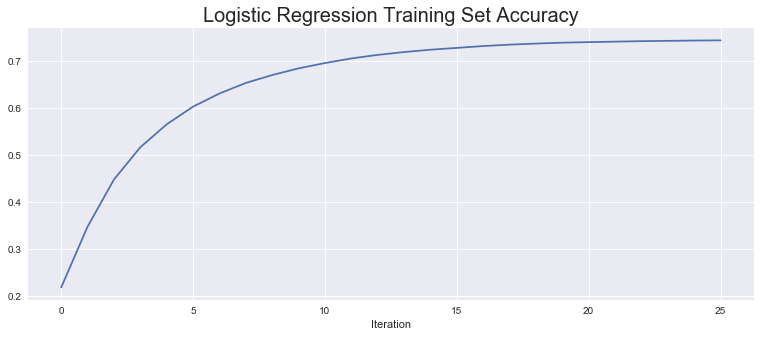

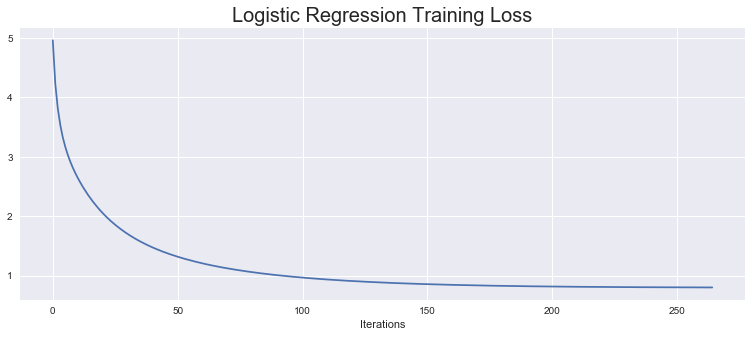

In [61]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(13)
mpl.style.use('seaborn')
plt.plot(accuracy)
plt.title('Logistic Regression Training Set Accuracy',fontsize=20)
plt.xlabel("Iteration")

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(13)
mpl.style.use('seaborn')
plt.plot(J[1:])
plt.title('Logistic Regression Training Loss',fontsize=20)
plt.xlabel("Iterations")

### Batch Gradient Size vs Accuracy

Text(0.5, 0, 'Batch Gradient Size')

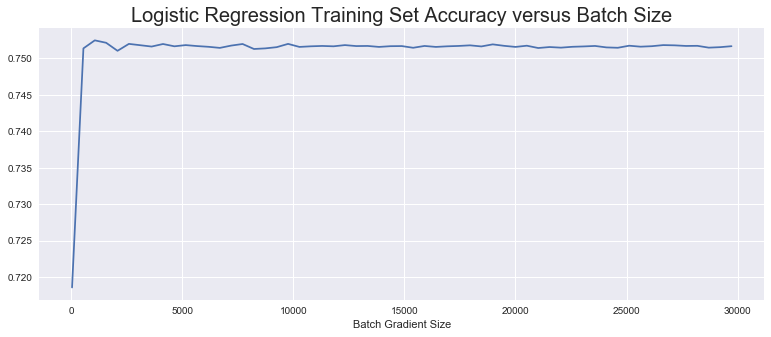

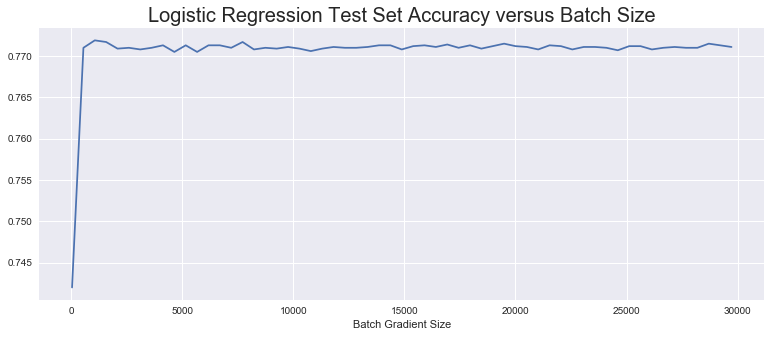

In [108]:
res = []
for i in range(len(accuracy)):
    res.append(accuracy[i][len(accuracy[i])-1])

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(13)
mpl.style.use('seaborn')
plt.plot(np.arange(32, int(trainX.shape[0]/2),512),res)
plt.title('Logistic Regression Training Set Accuracy versus Batch Size',fontsize=20)
plt.xlabel("Batch Gradient Size")


test_accuracy = []
for weight in w:
    test_accuracy.append(logreg.test(testX,testy,weight))
    
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(13)
mpl.style.use('seaborn')
plt.plot(np.arange(32, int(trainX.shape[0]/2),512),test_accuracy)
plt.title('Logistic Regression Test Set Accuracy versus Batch Size',fontsize=20)
plt.xlabel("Batch Gradient Size")